In [1]:
import warnings; warnings.simplefilter('ignore')

import sys
sys.path.insert(0, '/home/jcbyts/Repos/')

import Utils as U
import gratings as gt


import NDN3.NDNutils as NDNutils

which_gpu = NDNutils.assign_gpu()
from scipy.ndimage import gaussian_filter
from copy import deepcopy

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt  # plotting
import seaborn as sns

import NDN3.NDN as NDN
import NDN3.Utils.DanUtils as DU

*******************************************************************************************
---> getting list of available GPUs:
[0, 1]

---> getting GPU memory map:
{0: 270, 1: 354}

---> setting up GPU with largest available memory:
   ...picking GPU # 0
*******************************************************************************************

Done!


### Simulate some data and setup NDN

In [23]:
NT = 100000


gabor_radius = 6
karray = DU.gabor_array(gabor_radius, both_phases=True)
NP, NC = karray.shape
L = np.sqrt(NP).astype(int)
print(NP, NC, L)
# DU.plot_filters(filters=karray, filter_dims=[L,L])

num_lags = 10
TF = np.exp(-np.linspace(-4,4,num_lags)**2)

cc = 0

num_saclags = 40

stim_par = NDNutils.ffnetwork_params(
    input_dims=[1, L, L],
    time_expand=[num_lags],
    layer_sizes=[1, NC],
    layer_types=['temporal', 'normal'],
    act_funcs=['lin', 'lin'],
    normalization=[1, 0],
    reg_list={'d2t': [1e-5], 'd2x': [None,1e-4], 'l2':[1e-6,1e-6]}
)

sacon_par = NDNutils.ffnetwork_params(
    xstim_n=1,
    input_dims=[1, 1, 1],
    time_expand=[num_saclags],
    layer_sizes=[1, NC],
    layer_types=['temporal', 'normal'],
    act_funcs=['lin', 'lin'],
    normalization=[1, 0],
    reg_list={'d2t': [1e-5], 'd2x': [None], 'l2':[1e-6,1e-6]}
)

comb_par = NDNutils.ffnetwork_params(
    xstim_n=None,
    ffnet_n=[0,1],
    layer_sizes=[NC],
    layer_types=['mult'],
    act_funcs=['softplus']
)


ndn0 = NDN.NDN([stim_par, sacon_par, comb_par], noise_dist='poisson', ffnet_out=2)




169 12 13
Input dimensions: [1, 13, 13]
0: temporal (lin):  	[E1/I0] N
1: normal (lin):  	[E12/I0] 
Input dimensions: [1, 1, 1]
0: temporal (lin):  	[E1/I0] N
1: normal (lin):  	[E12/I0] 
0: mult (softplus):  	[E12/I0] 


Text(0.5, 0, 'saccade kernel')

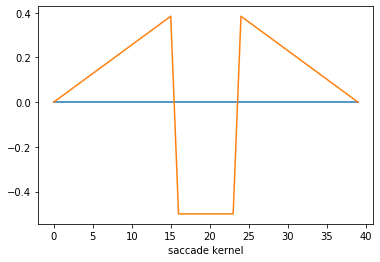

In [12]:
stim = np.random.randn(NT,L*L).astype('float32')
sacon =(np.random.rand(NT, 1) < .01).astype('float32')


ndn0.networks[0].layers[0].weights[:,0] = (TF/np.sum(TF)).astype('float32')
ndn0.networks[0].layers[1].weights = karray.astype('float32')

# saccade kernel
sk = np.linspace(0, 1, num_saclags)
sk[20:] = np.linspace(sk[19], 0, num_saclags-20)
sk[sk >.4] = -0.5

ndn1 = ndn0.copy_model()
ndn0.networks[1].layers[0].weights *= 0 # ndn0 has zero saccade gain
ndn1.networks[1].layers[0].weights = np.expand_dims(sk,axis=1).astype('float32') # ndn1 has saccade gain

ndn0.networks[1].layers[1].weights/=ndn0.networks[1].layers[1].weights
ndn1.networks[1].layers[1].weights/=ndn1.networks[1].layers[1].weights
ndn1.networks[1].layers[1].weights *= 4

ndn0.networks[2].layers[0].weights /= ndn0.networks[2].layers[0].weights
ndn1.networks[2].layers[0].weights /= ndn1.networks[2].layers[0].weights



plt.plot(ndn0.networks[1].layers[0].weights[:,0])
plt.plot(ndn1.networks[1].layers[0].weights[:,0])
plt.xlabel("saccade kernel")

# ndn0.networks[0].layers[1].biases += 0

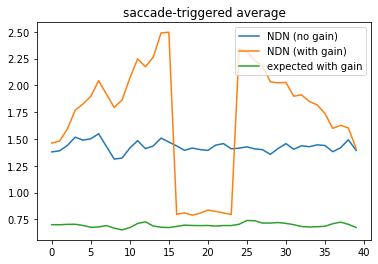

In [13]:
# generate prediction from the two models
Robs = ndn0.generate_prediction(input_data=[stim, sacon])

g = ndn0.generate_prediction(input_data=[stim, sacon], layer_target=0, ffnet_target=0)

Robs1 = ndn1.generate_prediction(input_data=[stim, sacon])

ev = np.where(sacon)[0]

cc = 0
m0, xax, wf = gt.psth(g[:,cc], ev, 0, num_saclags)
m, xax, wf = gt.psth(Robs[:,cc], ev, 0, num_saclags)
m1, xax, wf = gt.psth(Robs1[:,cc], ev, 0, num_saclags)

plt.plot(xax, m)
plt.plot(xax, m1)
plt.title("saccade-triggered average")
plt.legend(["NDN (no gain)", "NDN (with gain)"])




Text(0.5, 1.0, 'residuals')

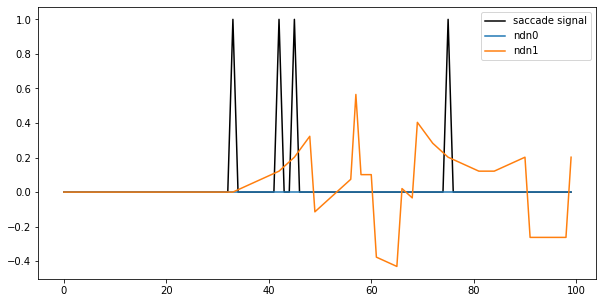

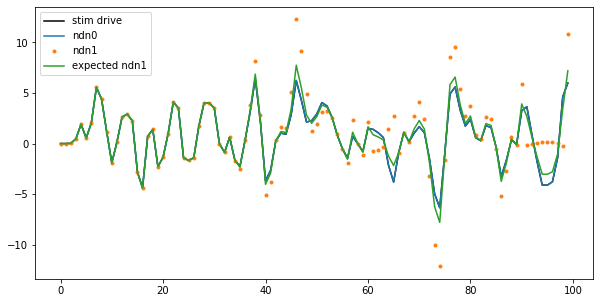

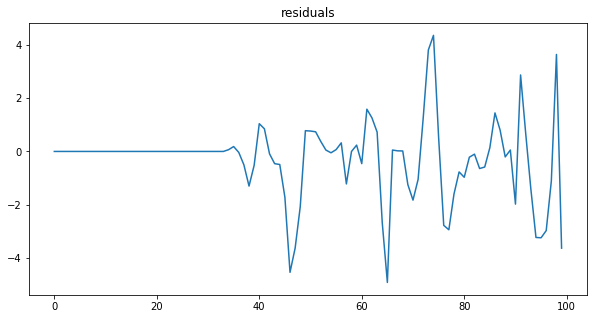

In [15]:
i = 0
ix = np.arange(i, i+100)


sacg0 = ndn0.generate_prediction(input_data=[stim, sacon], ffnet_target=1, layer_target=0)
sacg = ndn1.generate_prediction(input_data=[stim, sacon], ffnet_target=1, layer_target=0)

stimdrive = ndn1.generate_prediction(input_data=[stim, sacon], ffnet_target=0, layer_target=1)
gpre = ndn1.generate_prediction(input_data=[stim, sacon], pre_activation=True)
gpre0 = ndn0.generate_prediction(input_data=[stim, sacon], pre_activation=True)

plt.figure(figsize=(10,5))
plt.plot(sacon[ix], 'k')
plt.plot(sacg0[ix])
plt.plot(sacg[ix])
plt.legend(["saccade signal", "ndn0", "ndn1"])

plt.figure(figsize=(10,5))
plt.plot(stimdrive[ix,cc], 'k')
plt.plot(gpre0[ix,cc], '-')
plt.plot(gpre[ix,cc], '.')
expected = stimdrive[ix,cc:cc+1] * (1 + sacg[ix])
# expected = stimdrive[ix,cc:cc+1] + (sacg[ix])
f = plt.plot(expected, '-')
plt.legend(["stim drive", "ndn0", "ndn1", "expected ndn1"])

plt.figure(figsize=(10,5))
plt.plot(expected - gpre[ix,cc:cc+1])
plt.title('residuals')




In [16]:
adam_params = NDN.NDN.optimizer_defaults(opt_params={'use_gpu': True}, learning_alg='adam')

early_stopping = 100

adam_params['batch_size'] = 1000
adam_params['display'] = 30
adam_params['MAPest'] = True
adam_params['epochs_training'] = 1000
adam_params['early_stop'] = early_stopping
adam_params['early_stop_mode'] = 1
adam_params['epsilon'] = 1e-8
adam_params['data_pipe_type'] = 'data_as_var' # 'feed_dict'
adam_params['learning_rate'] = 1e-3



In [17]:
# fit stimulus only model
glm_par = NDNutils.ffnetwork_params(
    input_dims=[1, L, L],
    time_expand=[num_lags],
    layer_sizes=[1, NC],
    layer_types=['temporal', 'normal'],
    act_funcs=['lin', 'softplus'],
    normalization=[1, 0],
    reg_list={'d2t': [1e-5], 'd2x': [None,1e-4], 'l2':[1e-6,1e-6]}
)

glm = NDN.NDN([glm_par], noise_dist='poisson')

opt_params = NDN.NDN.optimizer_defaults(opt_params={'use_gpu': True, 'display': True}, learning_alg='lbfgs')
opt_params['maxiter'] = 10000

Ui, Xi = NDNutils.generate_xv_folds(NT)

_ = glm.train(input_data=[stim], output_data=Robs, train_indxs=Ui, test_indxs=Xi,
    learning_alg='lbfgs', opt_params=opt_params, use_dropout=False)

print("Done")

Input dimensions: [1, 13, 13]
0: temporal (lin):  	[E1/I0] N
1: normal (softplus):  	[E12/I0] 
Done


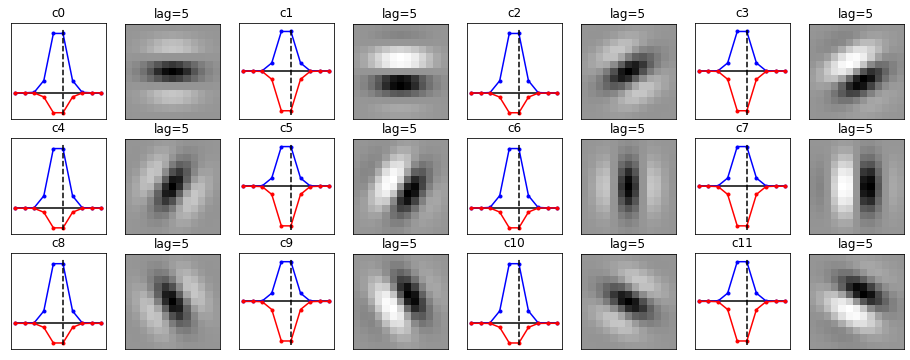

In [21]:
DU.plot_3dfilters(glm)

In [24]:
# try fitting the model
ndn2 = NDN.NDN([stim_par, sacon_par, comb_par], noise_dist='poisson', ffnet_out=2)

ndn2.networks[0].layers[0].weights = deepcopy(glm.networks[0].layers[0].weights)

v2f = ndn2.fit_variables(layers_to_skip=[[0],[],[0]], fit_biases=False)

RobsTrain = np.random.poisson(Robs1.copy())
_ = ndn2.train(input_data=[stim, sacon], output_data=RobsTrain, train_indxs=Ui, test_indxs=Xi,
    learning_alg='adam', opt_params=adam_params, use_dropout=False)

Epoch 0000:  avg train cost =     0.7108,  avg test cost =     0.7077,  reg penalty =     0.0022
Epoch 0029:  avg train cost =    -0.0990,  avg test cost =    -0.1178,  reg penalty =     0.0003
Epoch 0059:  avg train cost =    -0.1118,  avg test cost =    -0.1320,  reg penalty =     0.0004
Epoch 0089:  avg train cost =    -0.1118,  avg test cost =    -0.1320,  reg penalty =     0.0004
Epoch 0119:  avg train cost =    -0.1118,  avg test cost =    -0.1320,  reg penalty =     0.0004

*** early stop criteria met...stopping train now...
     ---> number of epochs used: 145,  end cost: -1.578786
     ---> best epoch: 105,  best cost: -1.580307



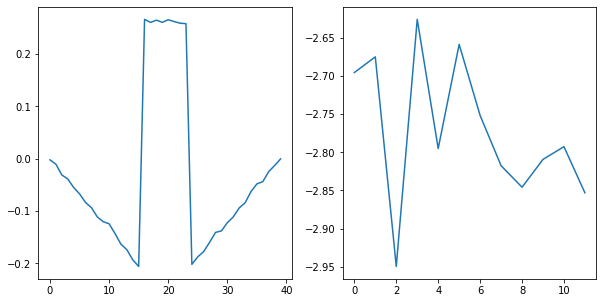

In [25]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(ndn2.networks[1].layers[0].weights)
plt.subplot(122)
plt.plot(ndn2.networks[1].layers[1].weights.T)

